<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA4_Phase1/blob/master/S9_Master_Model_ResNet_Gradcam_Albumentations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Mounting the drive and copying the code from github to drive
from google.colab import drive 
drive.mount('/content/gdrive')
%cd gdrive/My Drive/project_folder
! ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/project_folder
Untitled0.ipynb


In [3]:
!git clone https://github.com/anilbhatt1/Deep_Learning_EVA4_Phase1

Cloning into 'Deep_Learning_EVA4_Phase1'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 869 (delta 27), reused 0 (delta 0), pack-reused 808
Receiving objects: 100% (869/869), 4.43 MiB | 7.88 MiB/s, done.
Resolving deltas: 100% (535/535), done.


In [4]:
%cd Deep_Learning_EVA4_Phase1/S9_Resnet_Gradcam_Albumentations
! ls

/content/gdrive/My Drive/project_folder/Deep_Learning_EVA4_Phase1/S9_Resnet_Gradcam_Albumentations
models	README.md


In [0]:
#!pip install torchviz

In [0]:
from __future__ import print_function
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from tqdm import tqdm
#from torchviz import make_dot
from PIL import Image
from tqdm import tqdm_notebook
import numpy as np
from models import Alb_data_transforms,Model,Dataloaders,Train_Losses,Test_losses

In [6]:
train = torchvision.datasets.CIFAR10('./data', train=True, download=True)

Extracting ./data/cifar-10-python.tar.gz to ./data


In [7]:
n = 0
s = np.zeros(3)
sq = np.zeros(3)
i = 0
for data, l in tqdm_notebook(train):
  x = np.array(data)/255                             # Image Normalization 
  s += x.sum(axis=(0,1))                             # Summing up x & y values across 3 channels - CIFAR 10 size is 32,32,3. Useful for mean 
  sq += np.sum(np.square(x), axis=(0,1))             # Summing up x^2 and y^2 values across 3 channels. Useful for std dev calculation
  n += x.shape[0]*x.shape[1]                         # Summing up no: of pixels.Each channel has 32x32. Final pixels per channel = # images * 32 *32
  i += 1

mu = s/n                               # mean = sum of pixel values/ no: of pixel values. Will return 3 element array as CIFAR10 has 3 channels
std = np.sqrt((sq/n - np.square(mu)))  # std dev = sqrt[sigma{x(i) - mean}^2/N]. Will return 3 element array as CIFAR10 has 3 channels
print('No: Of Train Images:', i, 'Channels Mean:',mu, 'Channels Stdev:',std, 'Channels squared sum mean:', sq/n, 'Total Pixles (N):', n)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """



No: Of Train Images: 50000 Channels Mean: [0.49139968 0.48215841 0.44653091] Channels Stdev: [0.24703223 0.24348513 0.26158784] Channels squared sum mean: [0.30249857 0.29176174 0.26781806] Total Pixles (N): 51200000


In [8]:
!pip install albumentations==0.4.5

In [0]:
import numpy as np
import albumentations as A

data_loader = Dataloaders.DataLoader(shuffle=True,batch_size=128,seed=1)

channels_mean  = (0.49139968, 0.48215841, 0.44653091)
channels_stdev = (0.24703223, 0.24348513, 0.26158784)
fillmeans = (np.array(channels_mean)*255).astype(np.uint8) # This is to fill additional space coming up while rotating image
              
test_transforms   = Alb_data_transforms.Albumentations_transform([A.Normalize(mean=channels_mean, std=channels_stdev)])
train_transforms  = Alb_data_transforms.Albumentations_transform([A.Rotate((-30.0, 30.0)),
                                                                  A.HorizontalFlip(),
                                                                  A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                                                                  A.Normalize(mean=channels_mean, std=channels_stdev),
                                                                  A.Cutout(num_holes=4) # fillvalue = default i.e. 0 as after normalizing mean is 0
                                                                 ])

In [10]:
train_data = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_data  = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
trainloader = data_loader.load(train_data)
testloader  = data_loader.load(test_data)

In [14]:
test_data  = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

Files already downloaded and verified


In [12]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
i = images[90].numpy()
print(np.max(i), np.min(i))

1.661974 -1.8674959


torch.Size([128, 3, 32, 32])
torch.Size([128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

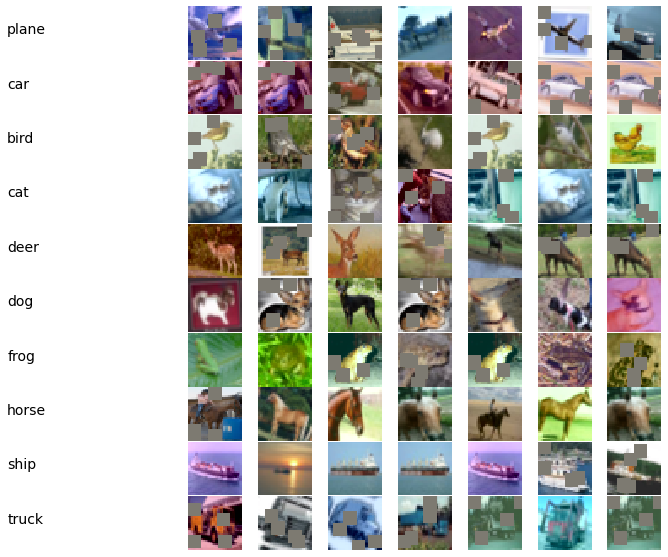

In [15]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt

channels_mean  = (0.49139968, 0.48215841, 0.44653091)
channels_stdev = (0.24703223, 0.24348513, 0.26158784)
def unnormalize(img):
  img = img.numpy().astype(dtype=np.float32)
  
  for i in range(img.shape[0]):
    img[i] = (img[i]*channels_stdev[i])+channels_mean[i]
  
  return np.transpose(img, (1,2,0))


dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

num_classes = 10
# display 7 images from each category. 
class_names = ['plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck']

row, col = 10, 8
num_images = 7
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.01, wspace=0.01)
for class_num in range(num_classes):
    idx = np.random.choice(np.where(labels[:]==class_num)[0], num_images)
    ax = plt.subplot(row, col,class_num*col+1)
    ax.text(-1.5, 0.5, class_names[class_num], fontsize=14)
    plt.axis('off')
    for j in range(1, num_images+1):
      plt.subplot(row, col, class_num*col+j+1)
      plt.imshow(unnormalize(images[idx[j-1]]), interpolation='none')
      plt.axis('off')
plt.show()

In [16]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model.ResNet18()
model.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [0]:
train_loss = Train_Losses.Train_loss()
test_loss  = Test_losses.Test_loss()

# Train and Test the model 

In [18]:
EPOCH     = 2
L2_factor = 0.0001
L1_factor = 0.0005
OPTIMIZER = optim.SGD(model.parameters(), lr=0.025, momentum=0.9,weight_decay=L2_factor)
train_loss_all = []
train_acc_all  = []
test_loss_all  = []
test_acc_all   = []

for epoch in range(EPOCH):

    print("EPOCH:", epoch)
    train_losses, train_acc = train_loss.train_loss_calc(model,device,train_loader=trainloader,optimizer=OPTIMIZER,epoch=EPOCH,factor=L1_factor)
    test_losses, test_acc   = test_loss.test_loss_calc(model,device,test_loader=testloader)

    train_loss_all.extend(train_losses)
    train_acc_all.extend(train_acc)
    test_loss_all.extend(test_losses)
    test_acc_all.extend(test_acc)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Train Loss = 1.3305281400680542 Batch Id = 390 Train Accuracy = 41.80: 100%|██████████| 391/391 [00:33<00:00, 11.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.3225, Test Accuracy: 55.55

EPOCH: 1


Train Loss = 1.0241148471832275 Batch Id = 390 Train Accuracy = 59.96: 100%|██████████| 391/391 [00:33<00:00, 11.58it/s]



Test set: Average loss: 0.9720, Test Accuracy: 66.65



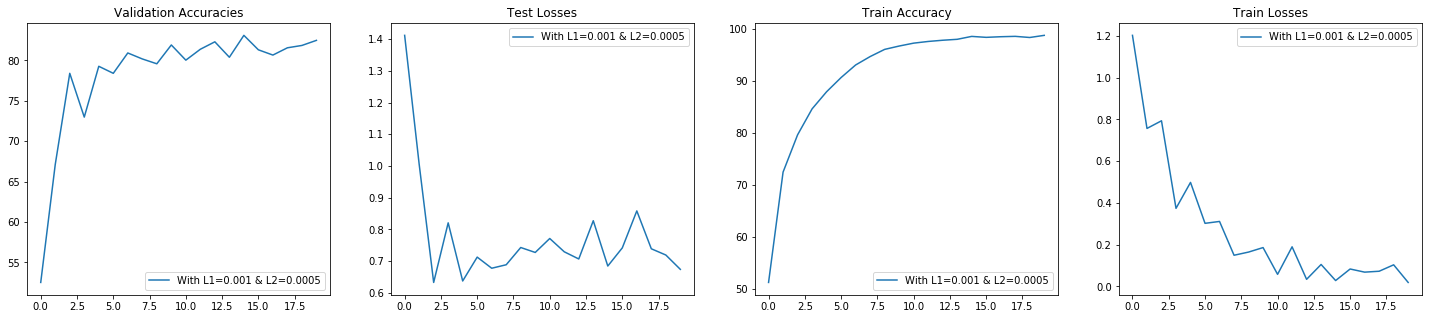

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
    
figure = plt.figure(figsize=(25,5))
labels = ['With L1=0.001 & L2=0.0005']

plt.subplot(1,4,1)
plt.title("Validation Accuracies")
plt.plot(test_acc_all,label=labels[0])
plt.legend(loc="best")

plt.subplot(1,4,2)
plt.title("Test Losses")
plt.plot(test_loss_all,label=labels[0])
plt.legend(loc="best")

plt.subplot(1,4,3)
plt.title("Train Accuracy")
plt.plot(train_acc_all,label=labels[0])
plt.legend(loc="best")   

plt.subplot(1,4,4)
plt.title("Train Losses")
plt.plot(train_loss_all,label=labels[0])
plt.legend(loc="best")    

In [0]:
train_acc_all